In [1]:
import numpy as np
import pandas as pd
import random
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)
import torch
from torch.nn import (
    Sequential,
    Linear,
    ReLU,
    Softmax,
    Sigmoid,
    CrossEntropyLoss,
    MSELoss,
    Conv2d,
    MaxPool2d,
    Flatten,
    ConvTranspose2d,
    Unflatten,
    LayerNorm,
    BCELoss
)
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Compose
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
%matplotlib inline

print("NumPy:", np.__version__)
print("Torch:", torch.__version__)

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

NumPy: 1.23.5
Torch: 1.13.1


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !mkdir Img_uint

In [4]:
# def gen_image_array(folder_path, stepSize, windowSize, split=[0.6,0.8]):
#     img_arr = []
#     i=0
#     for file in tqdm(os.listdir(folder_path)):
#         image_path = os.path.join(folder_path, file)
#         image = read_image(image_path)
#         for y in range(0, image.shape[1]-windowSize[0], stepSize):
#             for x in range(0, image.shape[2]-windowSize[1], stepSize):
#                 img_arr.append(image[:,y:y+windowSize[0],x:x+windowSize[1]])
#                 i+=1
#                 if i%1000 == 0:
#                     torch.save(torch.stack(img_arr),f"Img_uint/image_array_{i}.pt")
#                     img_arr = []
#     torch.save(torch.stack(img_arr),f"Img_uint/image_array_{i}.pt")
#     return i#, bbox_arr, windowSize

# gen_image_array("/content/drive/MyDrive/Astro_img", 200, (200, 200))

image_array = []
for file in os.listdir("Img_uint/"):
    image_array.extend(torch.load(os.path.join("Img_uint/",file)))

image_array = torch.stack(image_array)

In [5]:
def plot_metric(
    array,
    label=["train_loss", "val_loss", "train_acc", "val_acc"],
    log=True
):
    for array, label in zip(array, label):
        plt.plot(array, label=label)
    plt.legend()
    plt.ticklabel_format(axis="both",
                         style="sci",
                         scilimits=(0, 0),
                         useMathText=True)
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    if log:
        plt.ylabel("log_loss")
        plt.yscale("log")
    else:
        plt.ylabel("loss")
    plt.show()


def train_model(model, epochs, loss_fn, optim, train_loader, val_loader):
    train_loss = np.array([])
    val_loss = np.array([])
    # train_acc = []
    # val_acc = []
    pbar = trange(epochs, desc="Epoch", unit=" epoch", position=1)

    for epoch in pbar:
        train_batch_loss = []
        val_batch_loss = []
        # train_batch_acc = []
        # val_batch_acc = []

        model.train()
        pbar2 = tqdm(train_loader, desc="Batch", position=1, leave=False)
        for X_batch, y_batch in pbar2:
            y_pred = model(X_batch.to(device))
            loss = loss_fn(y_pred, y_batch.to(device))
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_batch_loss.append(loss.item())
            # train_batch_acc.append(
            #     np.mean(
            #         (y_pred.argmax(axis=1) == y_batch.argmax(axis=1))
            #         .cpu().detach().numpy()).item()
            # )
            pbar2.set_description(f"Train Loss {loss.item():.4f}")

        model.eval()
        with torch.no_grad():
            pbar3 = tqdm(val_loader, desc="Batch", position=2, leave=False)
            for X_batch, y_batch in pbar3:
                y_pred = model(X_batch.to(device))
                loss = loss_fn(y_pred, y_batch.to(device))
                val_batch_loss.append(loss.item())
                # val_batch_acc.append(
                #     np.mean(
                #         (y_pred.argmax(axis=1) == y_batch.argmax(axis=1))
                #         .cpu().detach().numpy()).item()
                # )
                pbar3.set_description(f"Val Loss {loss.item():.4f}")

            mean_train_batch_loss = np.mean(train_batch_loss)
            mean_val_batch_loss = np.mean(val_batch_loss)
            # mean_train_batch_acc = np.mean(train_batch_acc)
            # mean_val_batch_acc = np.mean(val_batch_acc)

            train_loss=np.concatenate((train_loss,np.asarray(train_batch_loss)))
            val_loss=np.concatenate((val_loss,np.asarray(val_batch_loss)))
            # train_acc.append(mean_train_batch_acc)
            # val_acc.append(mean_val_batch_acc)
            pbar.set_description(f"Epoch Loss [train: {mean_train_batch_loss:.4f},\
            val: {mean_val_batch_loss:.4f}]")

    return train_loss, val_loss


def pred_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_test = []
        for X_batch, y_batch in test_loader:
            y_pred_batch = model(X_batch.to(device))
            y_pred.extend(y_pred_batch)
            y_test.extend(y_batch)
    return torch.stack(y_pred).cpu(), torch.stack(y_test).cpu()

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return torch.clip(tensor + torch.randn(tensor.size()) * self.std + self.mean,0.,1.)
        
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [6]:
class CustomImageDataset_v2(Dataset):
    def __init__(self, images, transform=None, target_transform=None):
        self.images = images
        self.length = images.shape[0]
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = self.images[idx]/255
        x = self.transform(image) if self.transform else image
        y = self.target_transform(image) if self.target_transform else image
        
        return x, y

In [7]:
Astrodataset = CustomImageDataset_v2(
    image_array,
    transform=AddGaussianNoise(std=0.1, mean=0.0)
)

train_dataset, val_dataset, test_dataset = random_split(Astrodataset,[0.6,0.2,0.2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [8]:
latend_dim = 128
Autoencoder = Sequential(
    Conv2d(3, 32, 3,stride=(1,1), padding=(1,1)),
    ReLU(),
    MaxPool2d(2,2),
    Conv2d(32, 32, 3,stride=(1,1), padding=(1,1)),
    ReLU(),
    MaxPool2d(2,2),
    ConvTranspose2d(32, 32, 3,stride=(2,2), padding=(1,1), output_padding=(1,1)),
    ReLU(),
    ConvTranspose2d(32, 32, 3,stride=(2,2), padding=(1,1), output_padding=(1,1)),
    Conv2d(32, 3, 3,stride=(1,1), padding=(1,1)),
    Sigmoid(),

).to(device)
loss_fn = BCELoss()
optim = Adam(params=Autoencoder.parameters(), lr=1e-4)

In [9]:
metrics = train_model(
    Autoencoder, 
    epochs=100, 
    loss_fn=loss_fn,
    optim=optim, 
    train_loader=train_loader, 
    val_loader=val_loader
)

Epoch:   0%|          | 0/100 [00:00<?, ? epoch/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

Batch:   0%|          | 0/336 [00:00<?, ?it/s]

Batch:   0%|          | 0/112 [00:00<?, ?it/s]

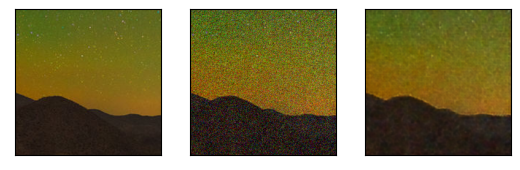

In [54]:
with torch.no_grad():
    x,y = train_dataset[random.randint(0,len(val_dataset))]
    y_pred = Autoencoder(x.view(1,3,200,200).to(device))
    show([y,x,y_pred.view(3,200,200)])

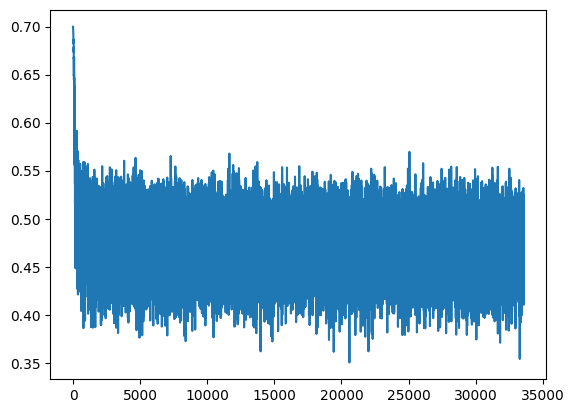

In [11]:
plt.plot(metrics[0])

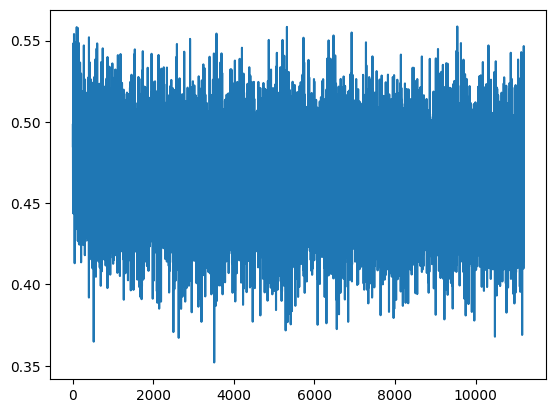

In [12]:
plt.plot(metrics[1])

In [34]:
torch.save(Autoencoder.state_dict(), "Autoencoder_state.pt")

In [35]:
torch.save(Autoencoder,"Autoencoder_object.pt")

In [37]:
torch.save(optim.state_dict(),"Optimizer_state.pt")